In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
import torchvision.transforms as transforms
import glob
import wandb

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from typing import List

In [ ]:
import random

import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb")
wandb.login(key=wandb_key)

# Data preparation

In [ ]:
config = dict(
    val_size=0.3,
    data_path="/kaggle/input/indoor-outdoor/",
    epochs=10,
    num_steps_stop=60_000,
    classes=2,
    batch_size=64,
    learning_rate=0.001,
    num_warmup_steps=300,
    num_training_steps=60_000,
    architecture="mobile_net_2")

In [ ]:
class IndoorDataset(Dataset):
    def __init__(self,root_dir: str, file_paths: List[str], transform=None):
        super().__init__()
        self.transform = transform
        self.i2c = {i:class_name for i, class_name in enumerate(os.listdir(root_dir))}
        self.c2i = {class_name:i for i, class_name in enumerate(os.listdir(root_dir))}
        self.file_paths = file_paths

    def __len__(self):
        pass
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        image = io.imread(file_name)
        file_class = os.path.basename(os.path.dirname(file_name))
        
        if self.transform:
            image = self.transform(image)
        return {'images': image, 'labels': self.c2i[file_class]}

In [ ]:
crop_size = 224
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Training with Wandb

In [ ]:
def get_data(config):
    path_file_folder = config["data_path"]
    all_files = glob.glob(f"{path_file_folder}*/*")
    train_files, val_files = train_test_split(all_files, test_size=config["val_size"])
    return train_files, val_files

def make_loader(files, is_train: bool, config):
    dataset = IndoorDataset(
        config["data_path"],
        files,
        transform=train_transform if is_train else val_transform
    )
    loader = DataLoader(dataset=dataset,
                         batch_size=config["batch_size"] * 2 if is_train  else config["batch_size"], 
                         shuffle=is_train,
                         pin_memory=False,
                         num_workers=2
                       )
    return loader

In [ ]:

from torch.optim.lr_scheduler import LambdaLR
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / max(1, num_warmup_steps)
        return max(0.00001, float(num_training_steps - current_step) / max(1, num_training_steps - num_warmup_steps))

    return LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
def make(config):
    # Make the data
    train_files, test_files = get_data(config)
    train_loader = make_loader(train_files[:], is_train=True, config=config)
    test_loader = make_loader(test_files[:], is_train=False, config=config)

    # Make the model
    if config["architecture"] == "resnet18":
        model = torchvision.models.resnet18()
        model.fc = nn.Linear(in_features=512, out_features=config['classes'], bias=True)
        model.to(device)
    elif config["architecture"] == "resnet34":
        model = torchvision.models.resnet34()
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=config['classes'], bias=True)
        model.to(device)
    elif config["architecture"] == "mobile_net_2":
        model = torchvision.models.mobilenet_v2()
        model.classifier[1] = nn.Linear(1280, config['classes'], bias=True)
        model.to(device)
    
    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = get_linear_schedule_with_warmup(optimizer, config["num_warmup_steps"], config["num_training_steps"])
    return model, train_loader, test_loader, criterion, optimizer, scheduler

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)
    model.train()
    # Run training and track with wandb
    total_batches = len(train_loader) * config["epochs"]
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(1,config["epochs"] + 1)):
        model.train()
        for data in tqdm(train_loader):
            images, labels = data["images"], data["labels"]
            loss, outputs = train_batch(images, labels, model, optimizer, scheduler, criterion)
            example_ct +=  len(images)
            batch_ct += 1
            
            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted.cpu().detach()
                labels =  labels.cpu().detach()
                correct = (predicted == labels).sum().item()
                total = labels.size(0)
                train_log(loss, example_ct, epoch, batch_ct, correct / total, scheduler.get_last_lr()[0])
            if config["num_steps_stop"] is not None and batch_ct >= config["num_steps_stop"]:
                break
        model.eval()
        with torch.no_grad():
            correct, total = 0, 0
            for data in tqdm(val_loader):
                images, labels = data["images"], data["labels"]
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu().detach() == labels.cpu().detach()).sum().item()

            print(f"Accuracy of the model on the {total} " +
                  f"test images: {correct / total:%}")
            wandb.log({"test_accuracy": correct / total})
        torch.save(model.state_dict(), f"/kaggle/working/saved_model_epoch_{epoch}.pt")
        if config["num_steps_stop"] is not None and batch_ct >= config["num_steps_stop"]:
            break

def train_batch(images, labels, model, optimizer, scheduler, criterion, ):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss, outputs

def train_log(loss, example_ct, epoch, batch_ct, correct, learning_rate):
    # Where the magic happens
    print(learning_rate)
    wandb.log({"epoch": epoch,
               "loss": loss,
               "num_images": example_ct,
               "step": batch_ct,
               "correct": correct,
               "lr": float(learning_rate)},
                step=batch_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")


def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for data in tqdm(test_loader):
            images, labels = data["images"], data["labels"]
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        wandb.log({"test_accuracy": correct / total})

In [ ]:
def model_pipeline(hyperparameters):
    with wandb.init(project="pytorch-demo", config=hyperparameters):
        config = wandb.config
    #     config = hyperparameters
        model, train_loader, test_loader, criterion, optimizer, scheduler = make(config)
    #     print(model
        train(model, train_loader, test_loader, criterion, optimizer, scheduler, config)
#         test(model, test_loader)
    return model

In [ ]:
model = model_pipeline(config)

In [ ]:
torch.save(model.state_dict(), "/kaggle/working/saved_model.pt")


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(torchvision.models.mobilenet_v2())

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()


# Выводы

Графики обучения можно найти по следующей ссылке: [wandb](https://wandb.ai/mishaya/pytorch-demo?workspace=user-mishaya).
Для обучения и валидации модели данные были разделены в соотношении 70% к 30%, валидационная часть составляет 30%.

Наилучшее качесто показала модлеь mobile-net_2, запуск под названием dancing-tiger-37. В прцессе обучения модель на 60_000 шагах, увидела более чем 6.5 мил. изображений. И смогла достичь точности более чем 95% на валидации. 

Точнось модели в зависимости от кол-во шагов обучения
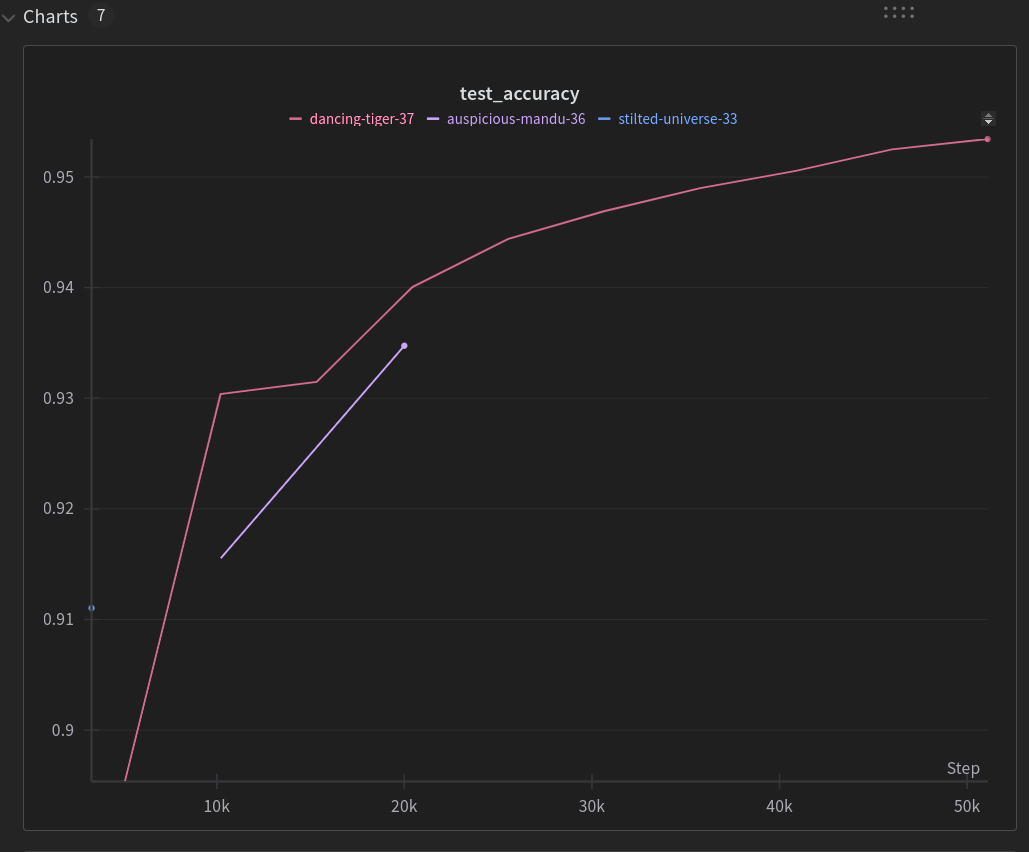

Использовались следующие параметры:
* architecture = "mobile_net_2"
* batch_size = 64
* classes = 2
* epochs = 10
* learning_rate = 0.001
* num_steps_stop = 60_000
* num_training_steps = 60_000
* num_warmup_steps = 300
* val_size = 0.3

График логгирования точности на обучающей выборке по батчам
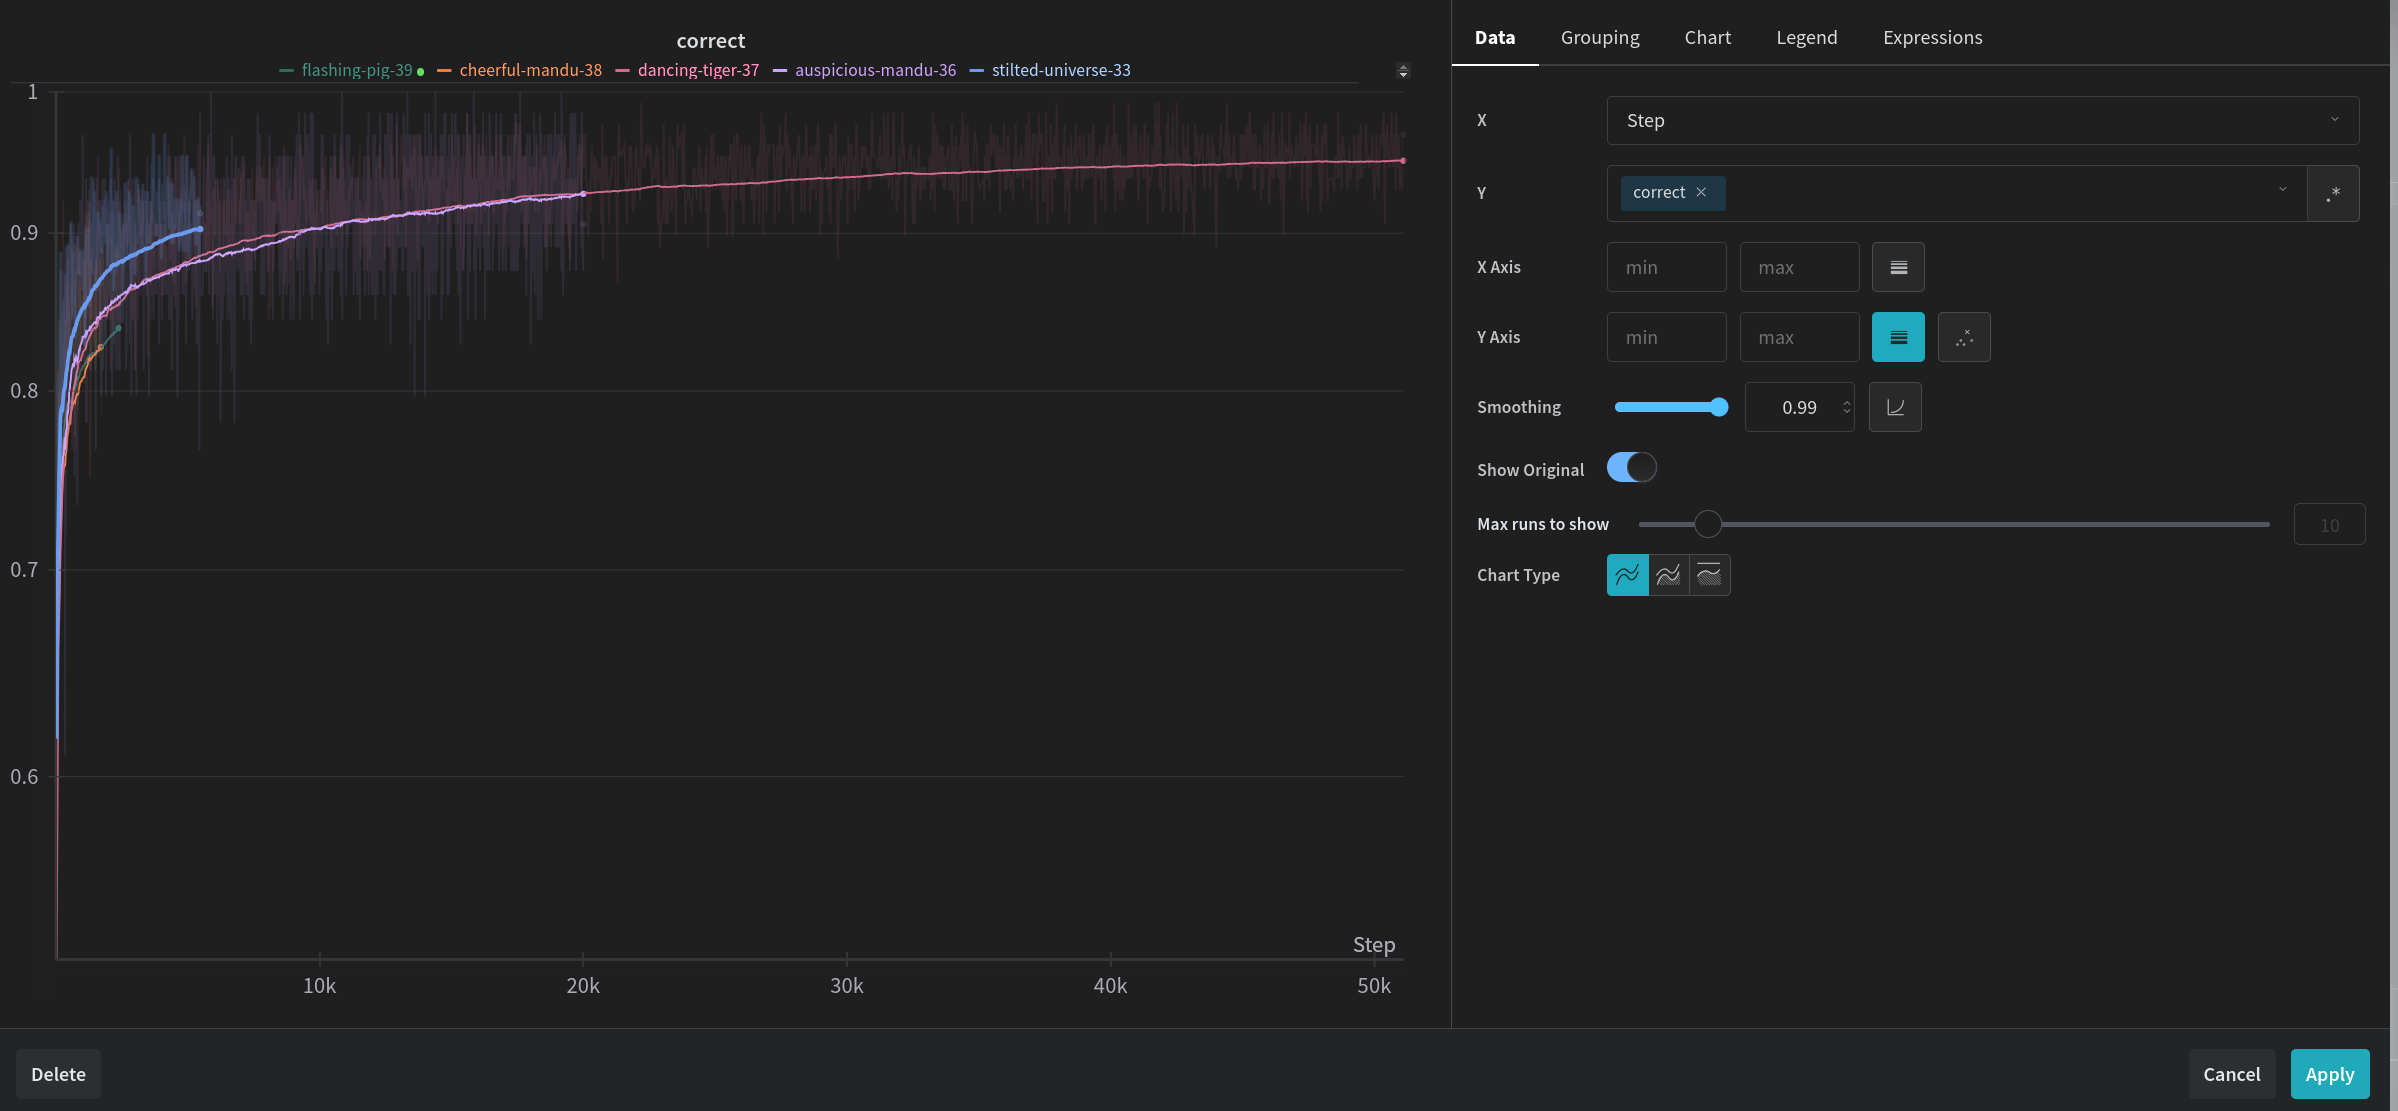

Грфик функции потерь на обучающей выборке
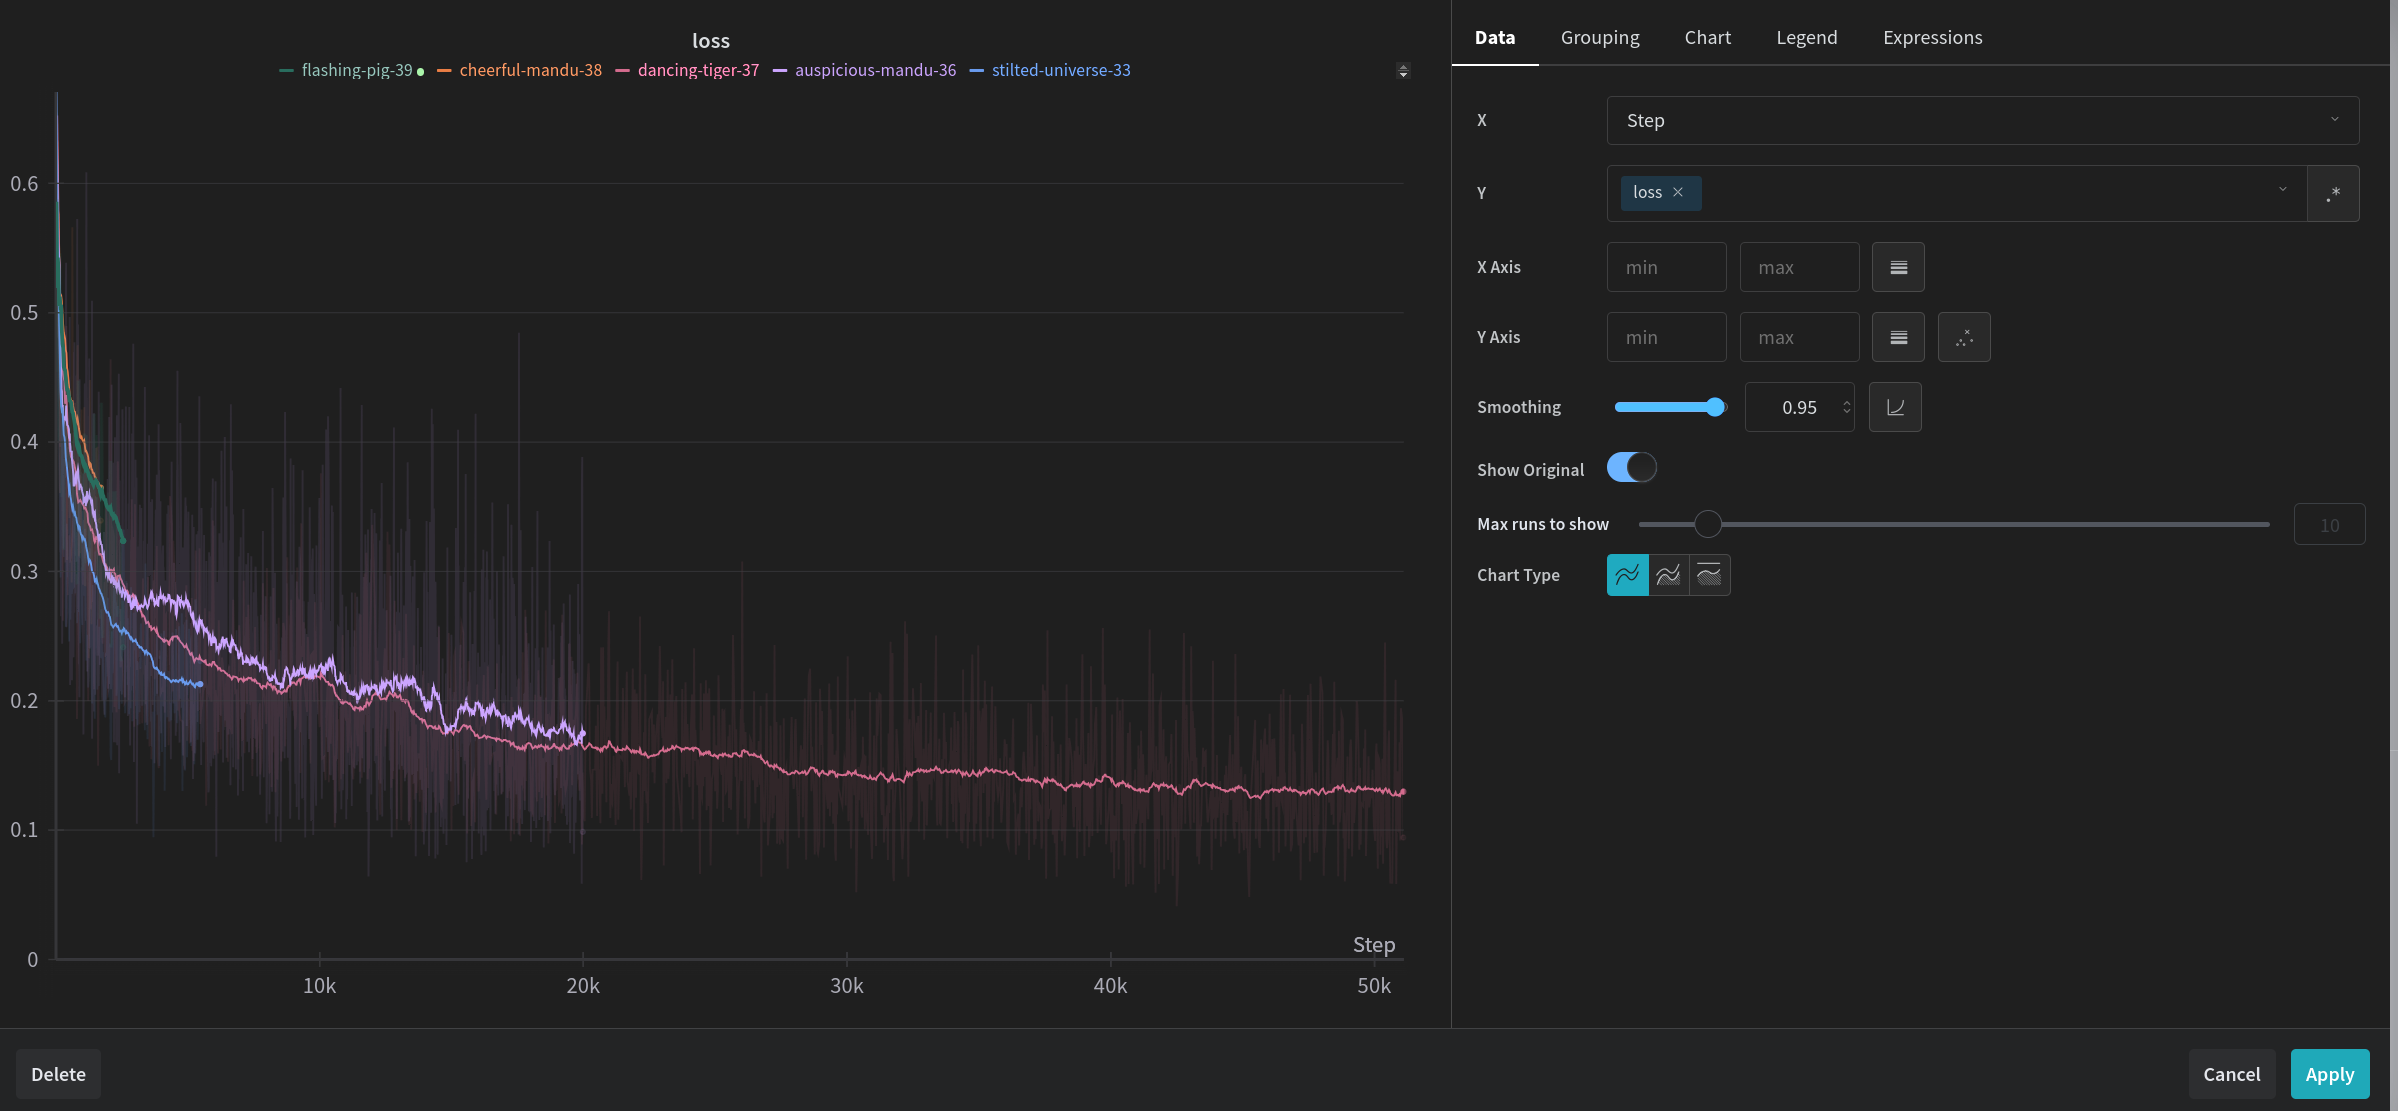

Также была попытка обучения resnet18, resnet34, в силу того, что не было произведено длительного обучения данных моделей не удалось достичь качество выше модели mobile_net. Также модель mobile_net была обучена с различным batch_size, 196 и 64.

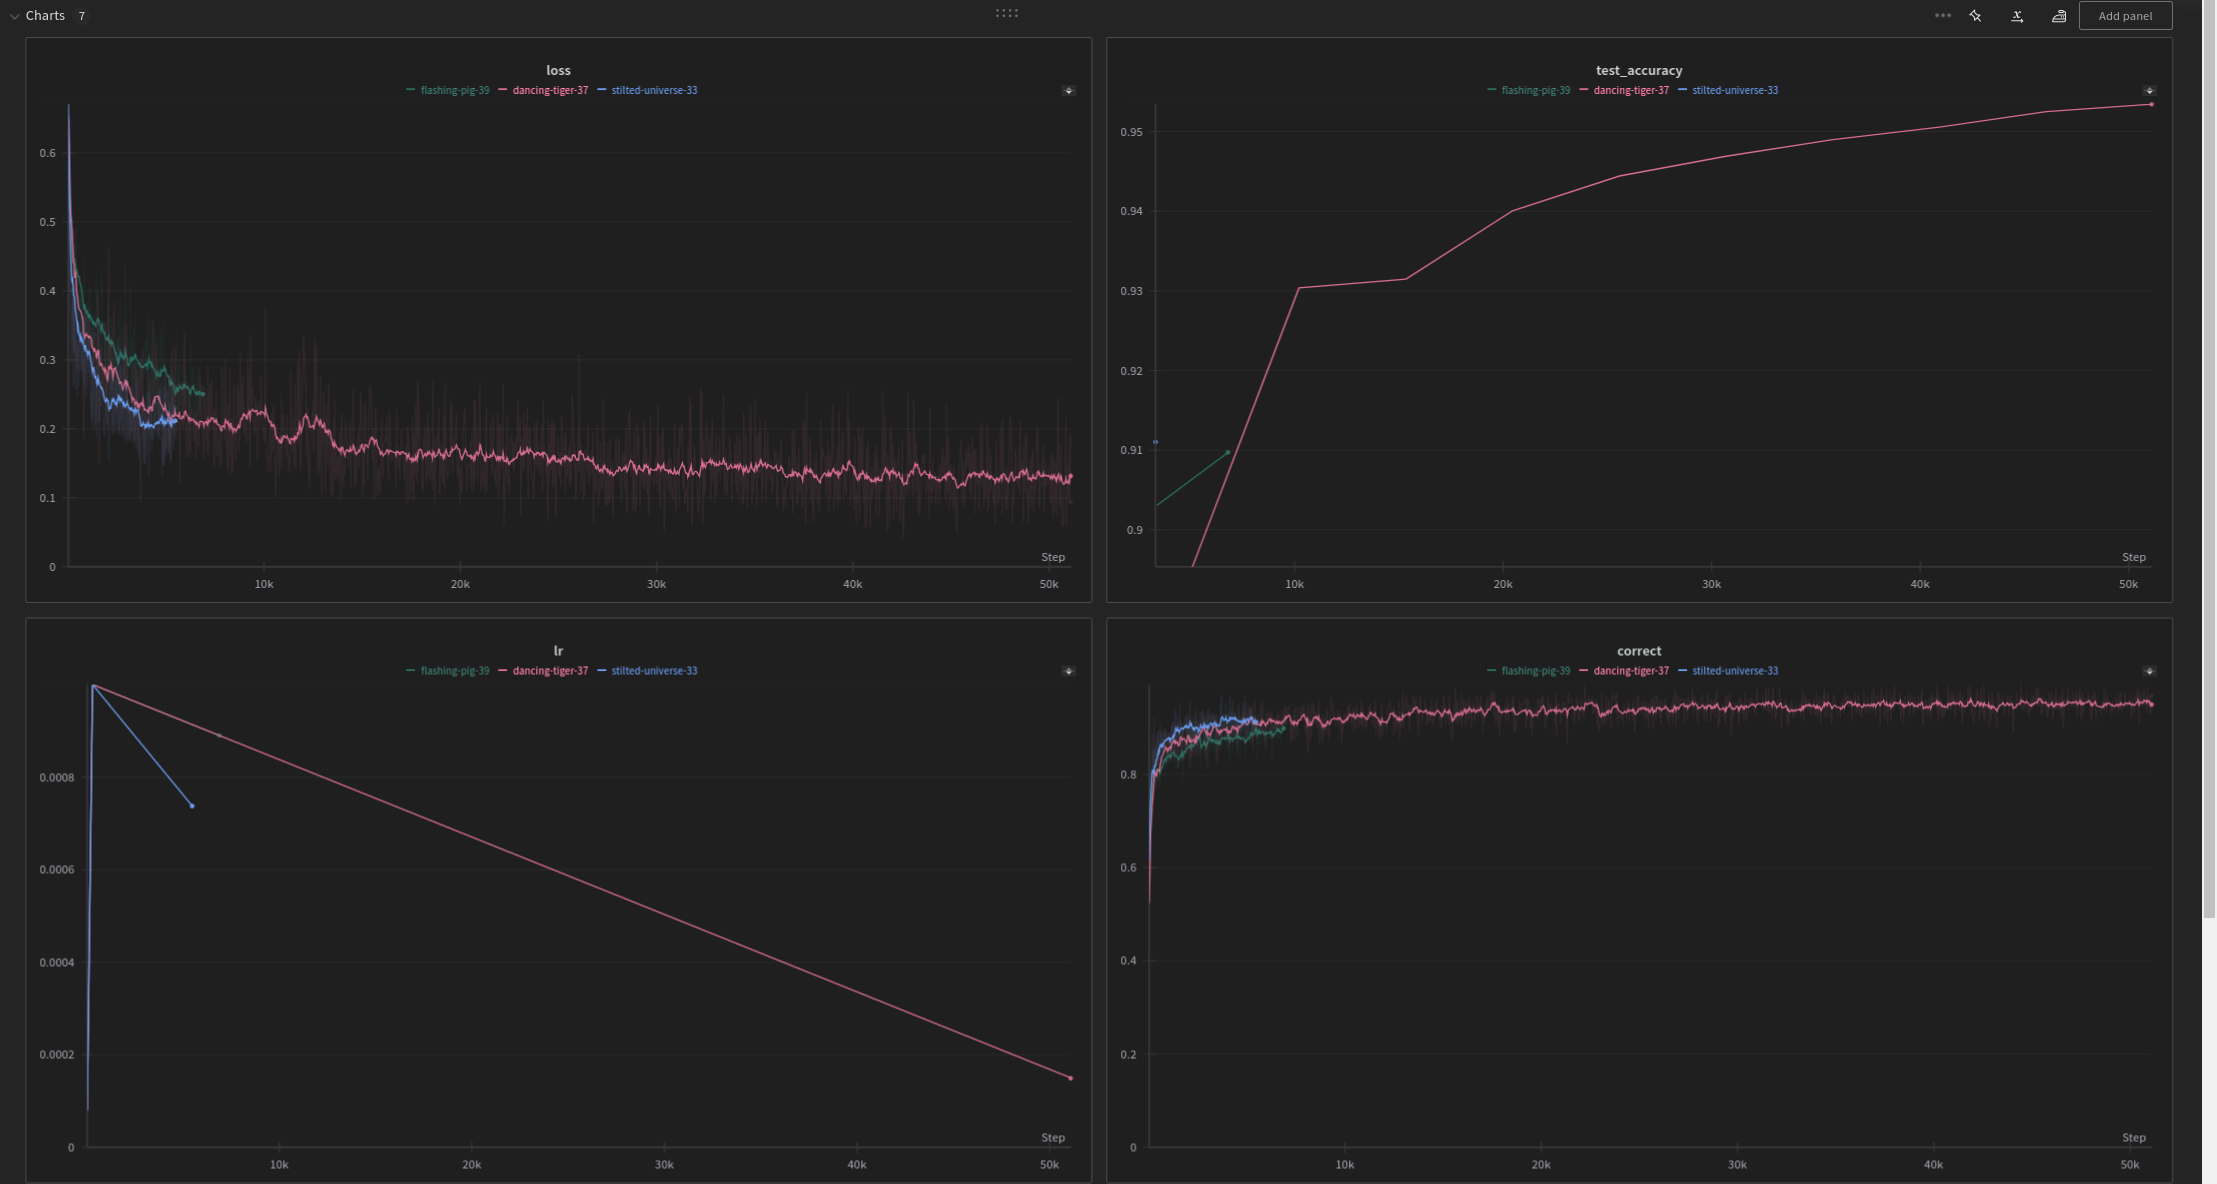